In [ ]:
!pip install transformers==4.12.5 --quiet
!pip install py_vncorenlp==0.1.3 --quiet
!pip install sentencepiece --quiet
!pip install tokenizer --quiet
!pip install underthesea --quiet
!pip install visen
!pip install pip install multiprocesspandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 63.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 KB 57.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━

In [ ]:
import json
import re
import string

import numpy as np
import pandas as pd
from google.colab import drive

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import py_vncorenlp
from underthesea import word_tokenize, text_normalize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import optim

from transformers import *
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import visen
from PIL import Image
import requests
from torchvision.io import read_image
import torchvision.transforms as transforms
from multiprocesspandas import applyparallel

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
le = LabelEncoder()

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/cfsdata/data1.csv')
df2 = pd.read_csv('/content/drive/My Drive/cfsdata/data2.csv')
df3 = pd.read_csv('/content/drive/My Drive/cfsdata/data3.csv')
df4 = pd.read_csv('/content/drive/My Drive/cfsdata/data4.csv')

In [ ]:
uetcfs_data = pd.concat([df1,df2,df3,df4])
uetcfs_data = uetcfs_data[uetcfs_data.Status != 1]

In [ ]:
py_vncorenlp.download_model(save_dir='/content/drive/My Drive/cfsdata')
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/My Drive/cfsdata')

The VnCoreNLP model is already!


In [ ]:
def word_segment(text):
  return "".join(["".join(sen) for sen in rdrsegmenter.word_segment(text_normalize(text))])

In [ ]:
def preprocess_text(text):
  text = re.sub(r'<[^>]*>', '', text)
  text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
  text = re.sub(r'\W', ' ', text)
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
  text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
  text = re.sub(r'\w*\d\w*', ' ', text).strip()
  text = re.sub(r'\s+', ' ', text, flags=re.I)
  text = text.lower()
  text = word_segment(text)
  return text

In [ ]:
uetcfs_data['content'] = uetcfs_data['content'].apply(preprocess_text)
uetcfs_data

,id,content,Sentiment,Học tập,Đời sống,Spam,Others,Status,Unnamed: 8
0,1.0,xin chào những người anh_em thiện lành bên hàn...,0.0,0.0,1.0,0.0,0.0,3,1.0
1,2.0,to tnh cnt love more can say can be my boyfrie...,1.0,0.0,NaN,0.0,1.0,4,1.0
2,3.0,sắp tới có giải lol sinh_viên không biết uet c...,0.0,0.0,1.0,0.0,0.0,4,1.0
3,4.0,hôm_nay tình_cờ xem được một trận của đội bóng...,1.0,0.0,NaN,0.0,1.0,4,1.0
4,5.0,chào em cô gái tháng vì một_chút tình_cờ mình ...,1.0,0.0,NaN,0.0,1.0,4,1.0
...,...,...,...,...,...,...,...,...,...
792,NaN,uet news thời_gian bắt_đầu năm_học mới và kế_h...,NaN,1.0,NaN,NaN,NaN,4,NaN
793,NaN,tri_ân ban chủ_nhiệm sguet nhiệm_kỳ bước qua n...,1.0,NaN,NaN,NaN,1.0,4,NaN
794,NaN,uet news thông_báo về việc tuyển_sinh chương_t...,NaN,1.0,NaN,NaN,NaN,4,NaN
795,NaN,uet news kết_quả đăng_ký học chính thức và mở ...,NaN,1.0,NaN,NaN,NaN,4,NaN


In [ ]:
uetcfs_data.loc[uetcfs_data['Status'].astype(float) == 2, 'Tag'] = 1
uetcfs_data.loc[uetcfs_data['Status'].astype(float) == 4, 'Tag'] = 1
uetcfs_data.loc[uetcfs_data['Status'].astype(float) == 3, 'Tag'] = 0
uetcfs_data.loc[uetcfs_data['Status'].astype(float) == 5, 'Tag'] = 0
uetcfs_data['Status'] = uetcfs_data['Tag']
uetcfs_data['Status'] = le.fit_transform(uetcfs_data['Status'])
uetcfs_data = uetcfs_data[['content', 'Status']]

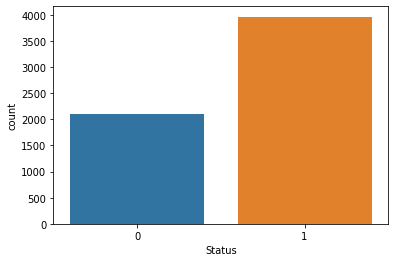

In [ ]:
sns.countplot(x='Status', data=uetcfs_data)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_set, test_data = train_test_split(uetcfs_data, test_size=0.1, random_state=42, shuffle=True)
train_data, val_data = train_test_split(train_set, test_size=0.28, random_state=42, shuffle=True)
train_data.shape, test_data.shape, val_data.shape

((3933, 2), (607, 2), (1530, 2))

In [ ]:
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [ ]:
# hyperparameters
MAX_LEN = 256
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def encoding(data, tokenizer, max_token_len=128):
  contents = data.content
  input_ids = []
  attention_masks = []

  for index, content in enumerate(contents):
    encoded = tokenizer.encode_plus(
      content,
      truncation=True,
      add_special_tokens=True,
      max_length=max_token_len,
      padding="max_length",
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids.append(encoded["input_ids"])
    attention_masks.append(encoded["attention_mask"])

  input_ids = torch.cat(input_ids,dim=0)
  attention_masks = torch.cat(attention_masks,dim=0)
  return input_ids, attention_masks

In [ ]:
from torch.utils.data import TensorDataset, random_split

train_input_ids, train_attention_masks = encoding(train_data, tokenizer, max_token_len=MAX_LEN)
val_input_ids, val_attention_masks = encoding(val_data, tokenizer, max_token_len=MAX_LEN)
test_input_ids, test_attention_masks = encoding(test_data, tokenizer, max_token_len=MAX_LEN)
train_encoded_label_tensors = torch.FloatTensor(np.array(train_data.Status))
val_encoded_label_tensors = torch.FloatTensor(np.array(val_data.Status))
test_encoded_label_tensors = torch.FloatTensor(np.array(test_data.Status))
        
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_encoded_label_tensors)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_encoded_label_tensors)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_encoded_label_tensors)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class BertBase(nn.Module):

  def __init__(self, n_classes, drop_out=0.1):
    super(BertBase, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.classifier = nn.Sequential(
        nn.Dropout(drop_out),
        nn.Linear(self.bert.config.hidden_size, n_classes),
        nn.Sigmoid()
    )

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    return self.classifier(output.pooler_output)

In [ ]:
class BertLSTM(nn.Module):

  def __init__(self, n_classes, drop_out=0.1):
    super(BertLSTM, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.lstm = nn.LSTM(768, 128, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(drop_out)
    self.fc = nn.Linear(256, n_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = output[0]
    enc_hiddens, (last_hidden, last_cell) = self.lstm(output)
    output = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
    output = self.dropout(output)
    output = self.fc(output)    
    return self.sigmoid(output)

In [ ]:
class BertCNN(nn.Module):
  def __init__(self, embedding_dim=768, n_filters=64, filter_sizes=[1, 2, 3, 5], output_dim=1, drop_out=0.1):
    super(BertCNN, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.convs1 = nn.ModuleList([nn.Conv2d(1, n_filters, (K, embedding_dim)) for K in filter_sizes])
    self.dropout = nn.Dropout(drop_out)
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = output[0].unsqueeze(0).permute(1, 0, 2, 3)
    output = [F.relu(conv(output)) for conv in self.convs1]
    output = [F.max_pool1d(i.squeeze(-1), i.size(2)).squeeze(2) for i in output]  
    output = torch.cat(output, 1)
    output = self.dropout(output)
    output = self.fc(output)    
    return self.sigmoid(output)

In [ ]:
model = BertLSTM(n_classes=1)
model = model.to(device)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    total_loss = total = 0
    total_correct = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    predictions = []
    labels = []
    for batch in progress_bar:

        label = batch[2].to(device)
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)

        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        output = model(input_ids, attention_masks).squeeze(dim=1)

        # Calculate how wrong the model is
        loss = criterion(output, label)
        
        numpy_logits = output.cpu().detach().numpy()
        predictions += list(np.where(numpy_logits >= 0.5, 1.0, 0.0))
        labels += list(label.cpu().detach().numpy())

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        

        # Record metrics
        total_loss += loss.item()
        total += len(label)

        progress_bar.set_postfix({'Training_loss': '{:.3f}'.format(loss.item()/len(batch))}, refresh=False)

    return accuracy_score(predictions, labels), total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    total_correct = 0
    predictions = []
    labels = []
    prob = []
    with torch.no_grad():
        progress_bar = tqdm(valid_loader, desc='Validating', leave=False)
        for batch in progress_bar:
            label = batch[2].to(device)
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)

            # Forwards pass
            output = model(input_ids, attention_masks).squeeze(dim=1)

            # Calculate how wrong the model is
            loss = criterion(output, label)

            numpy_logits = output.cpu().detach().numpy()
            prob += list(numpy_logits)
            predictions += list(np.where(numpy_logits >= 0.5, 1.0, 0.0))
            labels += list(label.cpu().detach().numpy())

            # Record metrics
            total_loss += loss.item()
            total += len(label)

    roc_auc = roc_auc_score(labels, prob)
    print(classification_report(labels, predictions))
    return accuracy_score(predictions, labels), total_loss / total, roc_auc


def predict_test(model, test_loader):
    model.eval()
    predictions = []
    prob = []
    labels = []
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Validating', leave=False)
        for batch in progress_bar:
            label = batch[2].to(device)
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)

            # Forwards pass
            output = model(input_ids, attention_masks)

            numpy_logits = output.cpu().detach().numpy()
            predictions += list(np.where(numpy_logits >= 0.5, 1.0, 0.0))
            prob += list(numpy_logits)

    return predictions, prob

In [ ]:
criterion = nn.BCELoss()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, eps=1e-8)
    
num_training_steps = EPOCHS * len(train_dataloader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
best_auc_score = 0

for epoch in range(EPOCHS):

    train_acc, train_loss = train_epoch(model, optimizer, train_dataloader)
    valid_acc, valid_loss, roc_auc = validate_epoch(model, val_dataloader)

    
    if roc_auc > best_auc_score:
      best_auc_score = roc_auc
      torch.save(model.state_dict(), '/content/drive/My Drive/cfsdata/bertLSTM_status.pt')
      # torch.save({'epoch': epoch,
      #           'model_state_dict': model.state_dict(),
      #           'optimizer_state_dict': optimizer.state_dict(),
      #           'loss': criterion,
      #           }, '/content/drive/My Drive/cfsdata/bertlstm_status_model.pt')

    print('Epoch {}/{}'.format(epoch, EPOCHS - 1))
    print('-' * 10)
    print('Training Loss: {:.2e} Acc: {:.8f}'.format(train_loss, train_acc))
    print('Validate Loss: {:.2e} Acc: {:.8f}'.format(valid_loss, valid_acc))
    print('ROC AUC Score: {: .8f}'.format(roc_auc))
    print()

Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validating:   0%|          | 0/48 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.87      0.35      0.50       533
         1.0       0.74      0.97      0.84       997

    accuracy                           0.75      1530
   macro avg       0.80      0.66      0.67      1530
weighted avg       0.78      0.75      0.72      1530

Epoch 0/4
----------
Training Loss: 1.67e-02 Acc: 0.74345283
Validate Loss: 1.57e-02 Acc: 0.75490196
ROC AUC Score:  0.79438033



Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validating:   0%|          | 0/48 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.47      0.56       533
         1.0       0.76      0.89      0.82       997

    accuracy                           0.74      1530
   macro avg       0.72      0.68      0.69      1530
weighted avg       0.73      0.74      0.73      1530

Epoch 1/4
----------
Training Loss: 1.52e-02 Acc: 0.76887872
Validate Loss: 1.54e-02 Acc: 0.74248366
ROC AUC Score:  0.79458356



Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validating:   0%|          | 0/48 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.82      0.39      0.53       533
         1.0       0.75      0.95      0.84       997

    accuracy                           0.76      1530
   macro avg       0.78      0.67      0.68      1530
weighted avg       0.77      0.76      0.73      1530

Epoch 2/4
----------
Training Loss: 1.42e-02 Acc: 0.78769387
Validate Loss: 1.55e-02 Acc: 0.75751634
ROC AUC Score:  0.78908865



Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validating:   0%|          | 0/48 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.52      0.58       533
         1.0       0.77      0.86      0.81       997

    accuracy                           0.74      1530
   macro avg       0.72      0.69      0.70      1530
weighted avg       0.73      0.74      0.73      1530

Epoch 3/4
----------
Training Loss: 1.26e-02 Acc: 0.81769641
Validate Loss: 1.59e-02 Acc: 0.74052288
ROC AUC Score:  0.78422980



Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validating:   0%|          | 0/48 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.52      0.58       533
         1.0       0.77      0.86      0.81       997

    accuracy                           0.74      1530
   macro avg       0.72      0.69      0.70      1530
weighted avg       0.73      0.74      0.73      1530

Epoch 4/4
----------
Training Loss: 9.76e-03 Acc: 0.88024409
Validate Loss: 1.79e-02 Acc: 0.74052288
ROC AUC Score:  0.76945282



In [ ]:
model = BertLSTM(n_classes=1)
best_model_cp = torch.load('/content/drive/My Drive/cfsdata/bertLSTM_status.pt')
model.load_state_dict(best_model_cp)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyError: ignored

In [ ]:
predictions, prob = predict_test(model, test_dataloader)

In [ ]:
guess = pd.DataFrame()
guess['content'] = test_data["content"]
guess['Status'] = list(map(float, prob))
guess

In [ ]:
roc_auc = roc_auc_score(test_data['Status'], guess['Status'])

In [ ]:
guess2 = pd.DataFrame()
guess2['content'] = test_data["content"]
guess2['Status'] = list(map(float, predictions))
guess2

In [ ]:
print(classification_report(test_data['Status'], guess2['Status']))
print(roc_auc)